<a href="https://colab.research.google.com/github/bsshreesha/slow_learners/blob/main/Weak_Students_2021Scheme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
import pandas as pd

def load_and_clean(filepath):
    try:
        df = pd.read_excel(filepath, header=9)
        df = df.iloc[2:]  # Skip header junk
        df.columns = df.columns.str.strip()  # Clean up column names

        # Extract the 'Student Name' column based on its position (assuming it's the second column)
        df['Student Name'] = df.iloc[:, 1]

        # Select the required columns: 'USN', 'Student Name', and 'Total'
        df = df[['2022 - 2023', 'Student Name', 'Unnamed: 3']]
        df.columns = ['USN', 'Student Name', 'Total']
        df.dropna(subset=['USN', 'Student Name', 'Total'], inplace=True)
        df['Total'] = pd.to_numeric(df['Total'], errors='coerce')
        df.dropna(subset=['Total'], inplace=True)
        return df.reset_index(drop=True)
    except Exception as e:
        print(f"❌ Error loading file: {filepath}")
        print(f"Error: {e}")
        return pd.DataFrame()

# Load all 3 internals
ia1 = load_and_clean('21CS382 IA1.xlsx')
ia2 = load_and_clean('21CS382 IA2.xlsx')
ia3 = load_and_clean('21CS382 IA3.xlsx')

# Display the first few rows of each DataFrame to verify
print("IA1:")
print(ia1.head())
print("\nIA2:")
print(ia2.head())
print("\nIA3:")
print(ia3.head())

IA1:
          USN         Student Name  Total
0  1JT21IS002        Aditya Sharma   25.0
1  1JT21IS004    Amogh N Koundinya   22.0
2  1JT21IS005        Aneeshkrishna   24.0
3  1JT21IS006  Anirudh G Bharadwaj   16.0
4  1JT21IS007        Anirudh Onkar   26.0

IA2:
          USN         Student Name  Total
0  1JT21IS002        Aditya Sharma   17.0
1  1JT21IS004    Amogh N Koundinya   14.0
2  1JT21IS005        Aneeshkrishna   16.0
3  1JT21IS006  Anirudh G Bharadwaj   10.0
4  1JT21IS007        Anirudh Onkar    9.0

IA3:
          USN         Student Name  Total
0  1JT21IS002        Aditya Sharma   29.0
1  1JT21IS004    Amogh N Koundinya   23.0
2  1JT21IS005        Aneeshkrishna   28.0
3  1JT21IS006  Anirudh G Bharadwaj   24.0
4  1JT21IS007        Anirudh Onkar   23.0


In [20]:
# === Step 2: Identify Weak Students from IA1 (<=18) ===
weak_threshold = 15
weak_students = ia1[ia1['Total'] <= weak_threshold].copy()
weak_students.columns = ['USN', 'Name', 'IA1_Total']

# === Step 3: Merge IA2 and IA3 marks ===
ia2_renamed = ia2.rename(columns={'Total': 'IA2_Total'})
ia3_renamed = ia3.rename(columns={'Total': 'IA3_Total'})

merged = weak_students.merge(ia2_renamed[['USN', 'IA2_Total']], on='USN', how='left')
merged = merged.merge(ia3_renamed[['USN', 'IA3_Total']], on='USN', how='left')

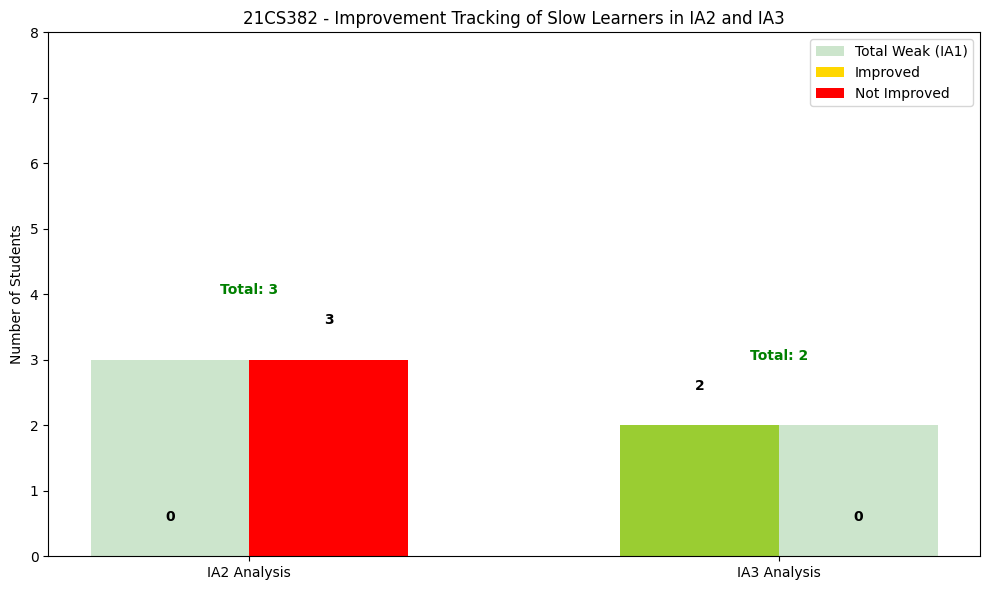

In [21]:
# === Step 4: Mark Improvement ===
def mark_improvement(before, after):
    if pd.notna(before) and pd.notna(after) and after > before:
        return 'Improved'
    else:
        return 'Not Improved'

merged['IA2_Improvement'] = merged.apply(lambda row: mark_improvement(row['IA1_Total'], row['IA2_Total']), axis=1)
merged['IA3_Improvement'] = merged.apply(lambda row: mark_improvement(row['IA2_Total'], row['IA3_Total']), axis=1)

# === Step 5: Summary Stats ===
total_students = len(ia1)
total_weak = len(merged)
ia2_improved = (merged['IA2_Improvement'] == 'Improved').sum()
ia2_not_improved = (merged['IA2_Improvement'] == 'Not Improved').sum()
ia3_improved = (merged['IA3_Improvement'] == 'Improved').sum()
ia3_not_improved = (merged['IA3_Improvement'] == 'Not Improved').sum()

# === Step 6: Horizontal Bar Chart Visualization ===
# === Compute required stats ===
import matplotlib.pyplot as plt

# === Calculations ===
total_weak = len(merged)
ia2_improved = (merged['IA2_Improvement'] == 'Improved').sum()
ia2_not_improved = (merged['IA2_Improvement'] == 'Not Improved').sum()

weak_ia2 = merged[merged['IA2_Total'] <= 24]
ia3_improved = (weak_ia2['IA3_Improvement'] == 'Improved').sum()
ia3_not_improved = (weak_ia2['IA3_Improvement'] == 'Not Improved').sum()

# === Plot Setup ===
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
bar_positions = [0, 1]  # IA2 and IA3

# === Background Bars ===
ax.bar(bar_positions[0], total_weak, color='green', alpha=0.2, width=bar_width * 2, label='Total Weak (IA1)')
ax.bar(bar_positions[1], len(weak_ia2), color='green', alpha=0.2, width=bar_width * 2)

# === Total Count Annotations ===
ax.text(bar_positions[0], total_weak + 1, f'Total: {total_weak}', ha='center', fontweight='bold', color='green')
ax.text(bar_positions[1], len(weak_ia2) + 1, f'Total: {len(weak_ia2)}', ha='center', fontweight='bold', color='green')

# === IA2 Bars (Reversed: Improved on Left) ===
ax.bar(bar_positions[0] - bar_width / 2, ia2_improved, color='gold', width=bar_width, label='Improved')
ax.bar(bar_positions[0] + bar_width / 2, ia2_not_improved, color='red', width=bar_width, label='Not Improved')

# === IA3 Bars (Reversed: Improved on Left) ===
ax.bar(bar_positions[1] - bar_width / 2, ia3_improved, color='yellowgreen', width=bar_width)
ax.bar(bar_positions[1] + bar_width / 2, ia3_not_improved, color='darkred', width=bar_width)

# === Value Annotations on Bars ===
for x, y in zip(
    [bar_positions[0] - bar_width / 2, bar_positions[0] + bar_width / 2,
     bar_positions[1] - bar_width / 2, bar_positions[1] + bar_width / 2],
    [ia2_improved, ia2_not_improved, ia3_improved, ia3_not_improved]
):
    ax.text(x, y + 0.5, str(y), ha='center', va='bottom', fontweight='bold', color='black')

# === Axis Labels and Titles ===
ax.set_xticks(bar_positions)
ax.set_xticklabels(['IA2 Analysis', 'IA3 Analysis'])
ax.set_ylabel("Number of Students")
ax.set_title("21CS382 - Improvement Tracking of Slow Learners in IA2 and IA3")
ax.set_ylim(0, max(total_weak, len(weak_ia2)) + 5)

ax.legend(loc='upper right')
plt.tight_layout()
plt.box(True)
plt.savefig("21CS382 - Performance_Summary.png", bbox_inches='tight')
plt.show()


In [22]:
# === Step 7: Save Everything to Excel ===
with pd.ExcelWriter('Student_IA_Improvement_Report_21CS382.xlsx') as writer:
    ia1.to_excel(writer, sheet_name='IA1_Cleaned', index=False)
    ia2.to_excel(writer, sheet_name='IA2_Cleaned', index=False)
    ia3.to_excel(writer, sheet_name='IA3_Cleaned', index=False)
    merged.to_excel(writer, sheet_name='Weak_Student_Analysis', index=False)

print("✅ Report complete: 'Student_IA_Improvement_Report.xlsx' and 'performance_summary.png'")

✅ Report complete: 'Student_IA_Improvement_Report.xlsx' and 'performance_summary.png'
